In [175]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy
import pywt
from pathlib import Path
from IPython.display import clear_output

In [176]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [177]:
def read_est_file(pathFile):
    arrays = []
    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        
        for value in lines:
            arrays.append(float(value.strip()))
    return arrays

In [178]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**8
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 256
Range resolution 0.04
Range bin 0.04303617205204089
Max range 11.017260045322468


In [179]:
def readRefFile(pathFile):
    beat_file =open(pathFile)
    beats = [float(br)for br in beat_file.read().split(",")]
    return beats

In [204]:
PERSON_NUMBER=4
clear_output(wait=True)
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_{0}.csv'.format(PERSON_NUMBER)
raw_data = readCsv(file_path)

breath_est_paper=read_est_file("../FMCW Radar/Heart Rate & Breathing Rate/Breath_{0}.csv".format(PERSON_NUMBER))
heart_est_paper=read_est_file("../FMCW Radar/Heart Rate & Breathing Rate/Heart_{0}.csv".format(PERSON_NUMBER))
breaths=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Breath_{0}.csv".format(PERSON_NUMBER))
heart=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Heart_{0}.csv".format(PERSON_NUMBER))

In [205]:
data_channel=raw_data[0]
print(data_channel.shape)
print(FRAME_COUNT*2*SAMPLE_PER_CHIRP)
single_chirp_data =np.array([data_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)])
double_chirp_data =np.array([data_channel[SAMPLE_PER_FRAME*i:SAMPLE_PER_FRAME*(i+1)]for i in range(0,FRAME_COUNT)])
print(single_chirp_data.shape)
print(double_chirp_data.shape)


(3072000,)
3072000
(6000, 256)
(6000, 512)


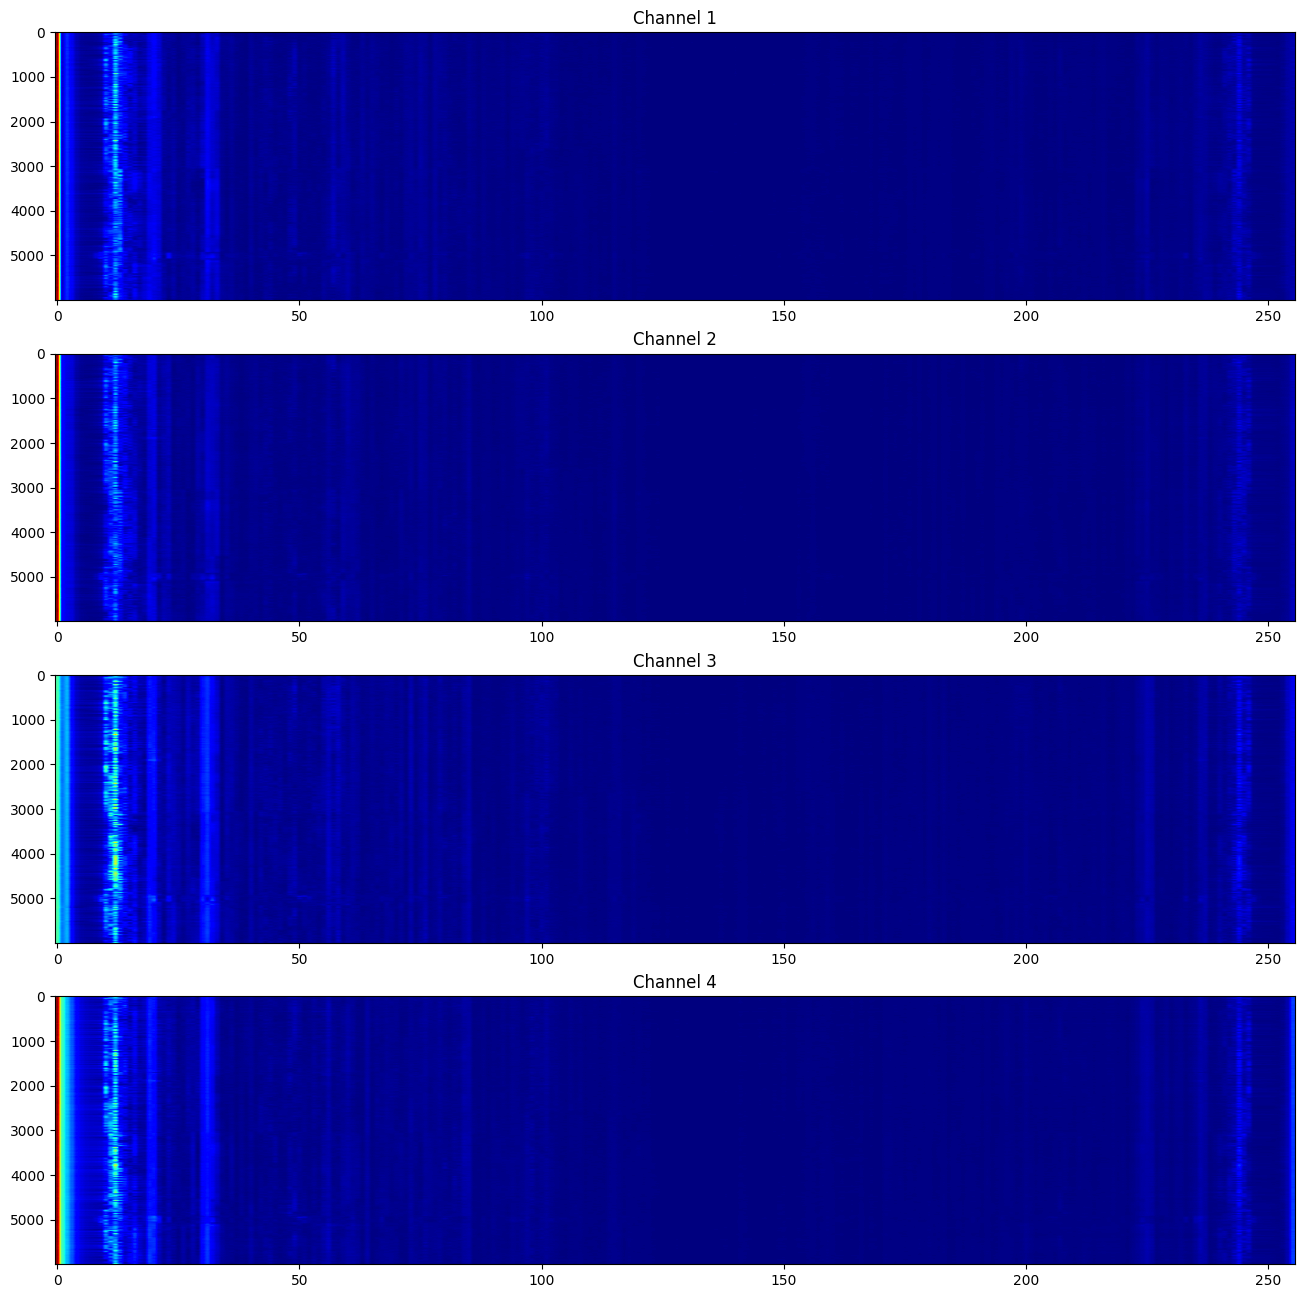

In [206]:
eveluate_channel =[]
for ii in range(0,4):
    tmp_channel=raw_data[ii]
    eveluate_channel.append(np.array([tmp_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)]))

plt.figure(figsize=(16,16))
for ii in range(0,4):
    plt.subplot(4,1,ii+1)
    plt.imshow(np.abs(np.fft.fft(eveluate_channel[ii])),cmap='jet',aspect='auto')
    plt.title("Channel {0}".format(ii+1))
plt.show()

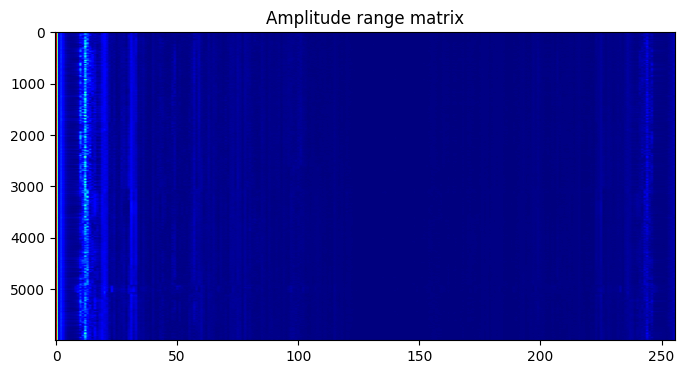

In [207]:
#calculate the amplitude range-matrix
est_channel=single_chirp_data
fft_output =np.fft.fft(est_channel,axis=1)
amplitude_range_matrix=np.abs(fft_output)
plt.figure(figsize=(8,4))
plt.imshow(amplitude_range_matrix,cmap='jet',aspect='auto')
plt.title("Amplitude range matrix")
plt.show()

128
[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254]
<class 'numpy.ndarray'>


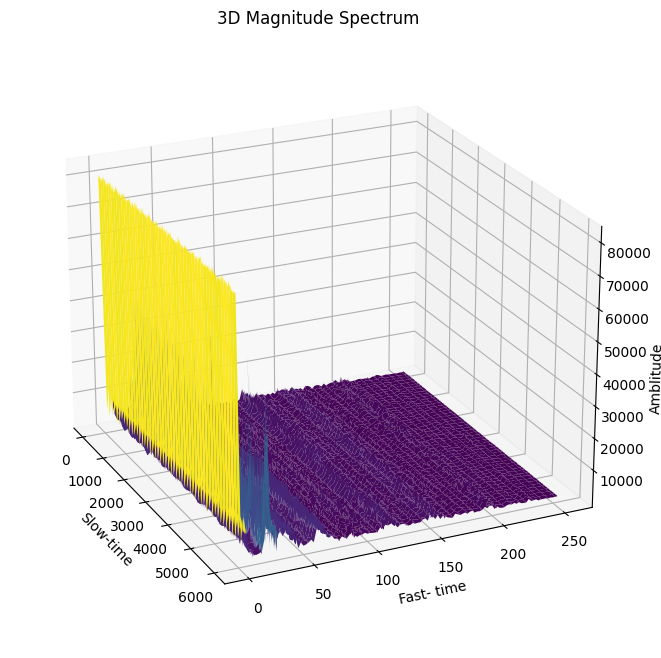

In [208]:
def genetate3DAmplitudeRangeMap(amplitudeRangeMap):
    
    num_range_profile =amplitudeRangeMap.shape[0]
    range_profile_len =amplitudeRangeMap.shape[1]

    frequencies = np.fft.fftfreq(range_profile_len)
    

    # Create grid for 3D plotting
    x = np.arange(num_range_profile)
    tmp=np.arange(range_profile_len)
    y = 2*tmp[:range_profile_len//2]
    
    
    print(len(y))
    print(y)
    print(type(y))

    x, y = np.meshgrid(x, y)

    # Magnitude of the FFT components for the first half of the frequencies
    fft_magnitude = amplitudeRangeMap[:, :range_profile_len//2]
    
    # Plotting
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the 3D surface
    ax.plot_surface(x, y, fft_magnitude.T, cmap='viridis')

    ax.set_title('3D Magnitude Spectrum')
    ax.set_xlabel('Slow-time')
    ax.set_ylabel('Fast- time')
    ax.set_zlabel('Amblitude')
    ax.view_init(elev=22.5, azim=-25)  # Change the angles as desired
    plt.show()
genetate3DAmplitudeRangeMap(amplitude_range_matrix)

(6000, 256)


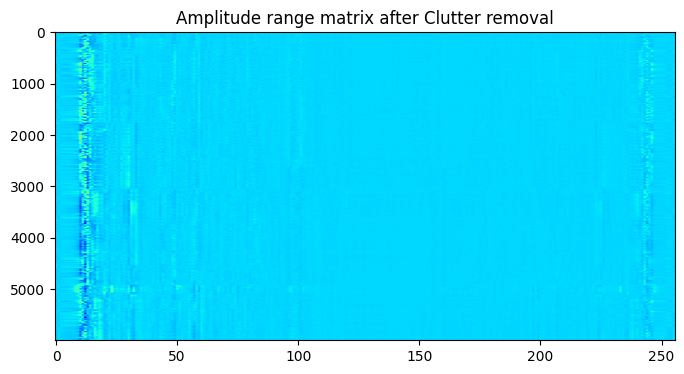

128
[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254]
<class 'numpy.ndarray'>


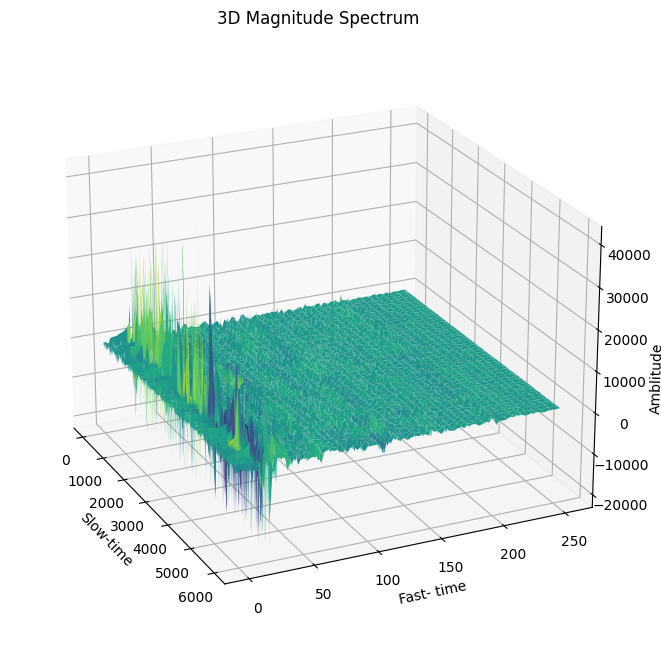

128
[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254]
<class 'numpy.ndarray'>


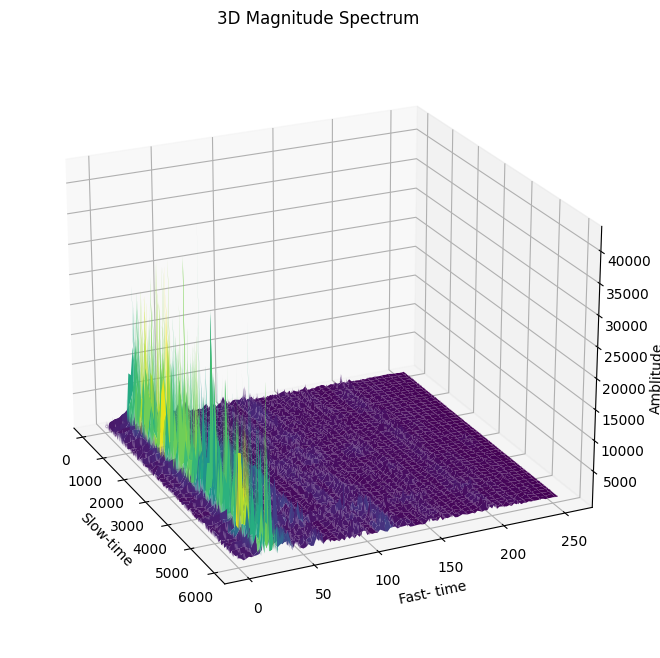

In [209]:
#clutter removal
(m,n)=amplitude_range_matrix.shape
amplitude_range_matrix_hat =np.zeros_like(amplitude_range_matrix)
print((m,n))
for column in range(0,n):
    # meanValueOfBin = np.average(amplitude_range_matrix[:,column])
    meanValueOfBin = np.sum(amplitude_range_matrix[:,column])/len(amplitude_range_matrix[:,column])
    meanValueOfBinArray=np.array([meanValueOfBin]*m)
    amplitude_range_matrix_hat[:,column] = amplitude_range_matrix[:,column] - meanValueOfBinArray

plt.figure(figsize=(8,4))
plt.imshow((amplitude_range_matrix_hat),cmap='jet',aspect='auto')
plt.title("Amplitude range matrix after Clutter removal")
plt.show()
amplitude_range_matrix_hat_abs=np.abs(amplitude_range_matrix_hat)
genetate3DAmplitudeRangeMap(amplitude_range_matrix_hat)
genetate3DAmplitudeRangeMap(amplitude_range_matrix_hat_abs)




[2942910.7123187054, 2706261.4315729635, 2779174.2344840365, 3176341.5264127823, 3533616.1106251264, 3815261.9978558104, 3983744.477715633, 4363812.085896164, 5733816.813735588, 8687561.682860821, 31139554.118129313, 24388447.57883131, 52909892.76610398, 30748131.309949704, 17584159.383119367, 13125384.06701323, 11825911.064847358, 8161583.2675653575, 7229682.6800331315, 5203991.326023852, 6579292.7732107565, 4464156.008271735, 4353193.114469558, 4530308.280474203, 3535332.4640563326, 2486253.3894916163, 2644870.312753437, 3484834.9020760497, 3788593.104810354, 3911542.8893826082, 6587728.345524587, 4866550.973695997, 4598711.93385763, 6088885.435073493, 2109456.7287134733, 2821047.448812373, 1739981.9058785997, 1648834.060823663, 1796278.8441563456, 1264460.3178715871, 1865963.205471293, 1803213.2164132483, 2584953.0298562422, 3676645.0202878825, 3740272.674978966, 2459850.254215467, 2305532.1782532325, 2079557.7762463028, 4206182.030309719, 5232845.143058109, 2231929.089287416, 24709

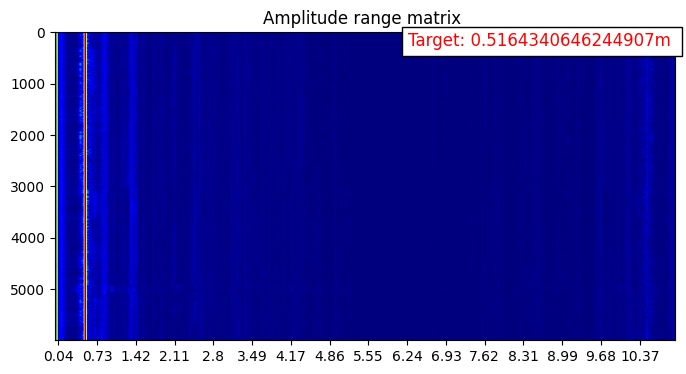

In [210]:
#calculate target location

range_for_plotting =range(1,FFT_SIZE,2**4)
range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]

(m,n)=amplitude_range_matrix_hat_abs.shape
nBins=[]
for column in range(0,n):
    binNTh=(np.sum(amplitude_range_matrix_hat_abs[:,column]))
    nBins.append(binNTh)
    
print(nBins)
nThBinTarget= np.argmax(nBins)
print("Target at bin  {0} with the sumation value {1}".format(nThBinTarget,nBins[nThBinTarget]))

tmp_amplitude_range_matrix=np.abs(fft_output)
tmp_amplitude_range_matrix[:,nThBinTarget]=99999

print(tmp_amplitude_range_matrix.shape)
plt.figure(figsize=(8,4))
plt.imshow(tmp_amplitude_range_matrix,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.text(tmp_amplitude_range_matrix.shape[1], 0, 'Target: {0}m '.format(nThBinTarget*RANGE_BIN), fontsize=12, color='red',
         horizontalalignment='right', verticalalignment='top',
         bbox=dict(facecolor='white', alpha=1))

plt.title("Amplitude range matrix ")
plt.show()
interesting_bin =nThBinTarget


/var/folders/7_/v8dw7hn50j7dbqpv0scn2tv80000gn/T/ipykernel_42633/2270932315.py:4: RuntimeWarning: divide by zero encountered in divide
  phaseArctan = (np.unwrap(np.arctan(imagParts/realParts)))


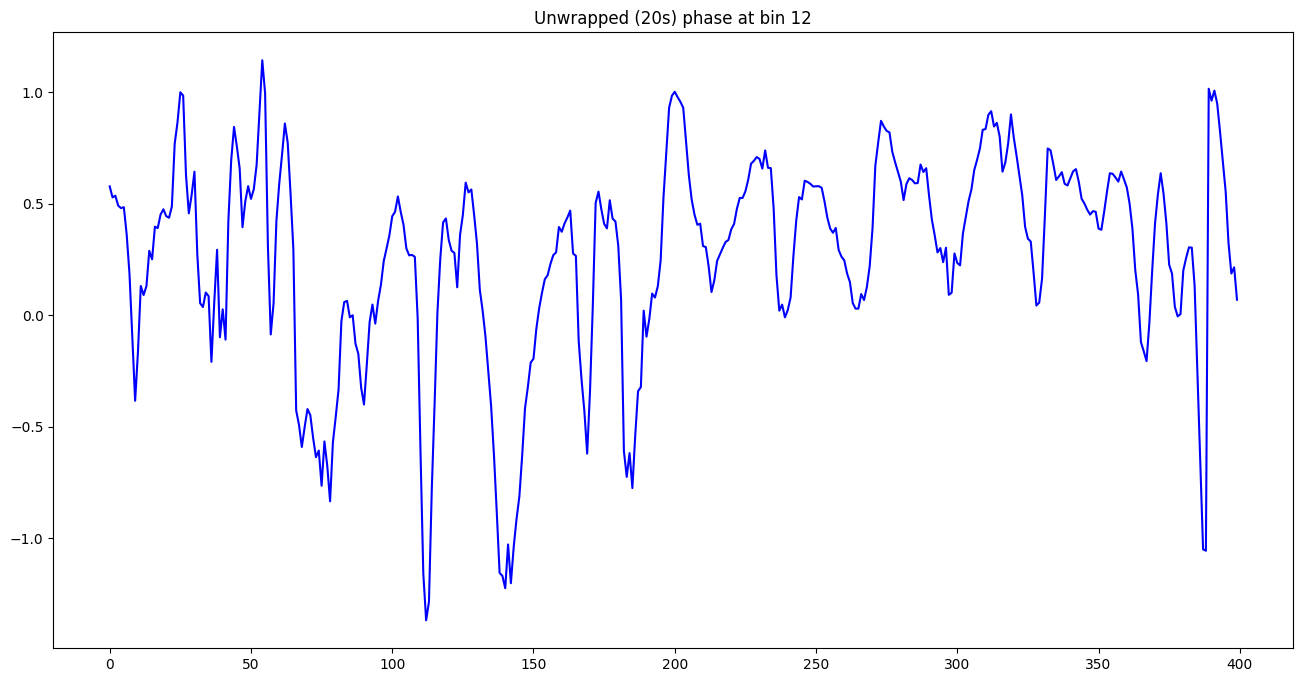

In [211]:
#calculate phase
realParts = np.real(est_channel[:,interesting_bin])
imagParts = np.imag(est_channel[:,interesting_bin])
phaseArctan = (np.unwrap(np.arctan(imagParts/realParts)))
phaseAngle=np.unwrap(np.angle(est_channel[:,interesting_bin]))

plt.figure(figsize=(16,8))
plt.plot(phaseArctan[0:400],color="blue")
plt.title("Unwrapped (20s) phase at bin {0}".format(nThBinTarget))
plt.show()

/var/folders/7_/v8dw7hn50j7dbqpv0scn2tv80000gn/T/ipykernel_42633/3077296562.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arctan(imagParts/realParts)[0:200],color="red")


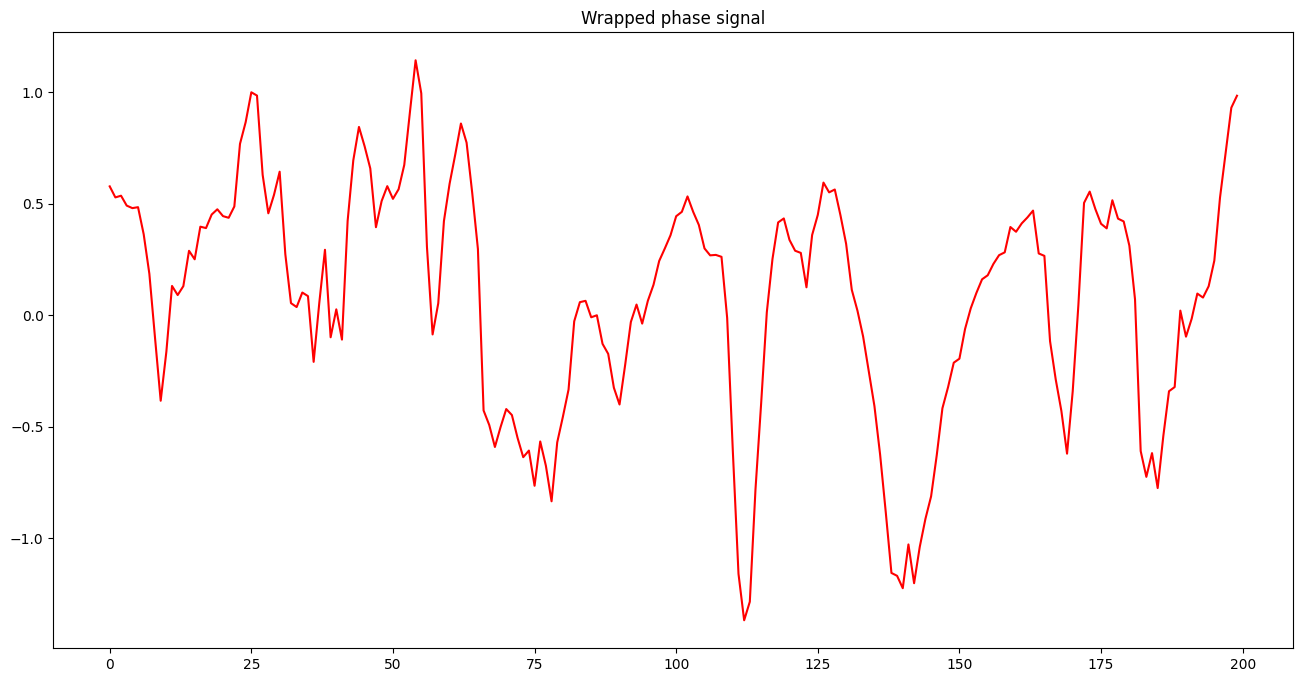

In [212]:
#calculate phase
realParts = np.real(est_channel[:,interesting_bin])
imagParts = np.imag(est_channel[:,interesting_bin])
plt.figure(figsize=(16,8))
plt.plot(np.arctan(imagParts/realParts)[0:200],color="red")
plt.title("Wrapped phase signal")
plt.show()

In [213]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

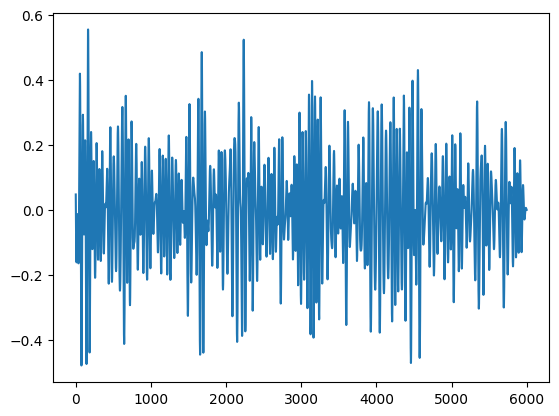

In [214]:
#filter to get breath component signal
filtered_breath_phase_arctan=filter_signal(phaseArctan,0.3,0.6,20,5)

plt.plot(filtered_breath_phase_arctan)
plt.show()
plt.show()

In [215]:
def estSignal(input_signal,sampling_rate,min_freq,max_freq):
    scales = np.arange(1, 32)  # Scales for wavelet transform
    wavelet = 'cmor'  # Complex Morlet wavelet
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(input_signal, scales, wavelet, sampling_period=1/sampling_rate)
    conditions =(np.where((frequencies >= min_freq) & (frequencies <= max_freq)))
    
    for c in conditions[0]:
        print(c,"  -   ",60* frequencies[c])
    # print(conditions)
    # indices = (conditions[0][0]+conditions[0][-1])//2
    indices = conditions[0][1]
    filtered_coeff =coefficients[indices]
    print(indices," <-----> ",60*frequencies[indices])

    return filtered_coeff

16   -    35.29411764705882
17   -    33.33333333333333
18   -    31.57894736842105
19   -    30.0
20   -    28.57142857142857
21   -    27.272727272727273
22   -    26.08695652173913
23   -    24.999999999999996
24   -    23.999999999999996
25   -    23.076923076923077
26   -    22.22222222222222
27   -    21.428571428571427
28   -    20.68965517241379
29   -    20.0
30   -    19.35483870967742
17  <----->  33.33333333333333


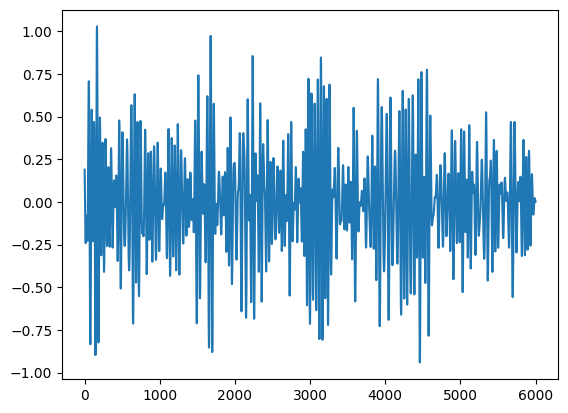

In [216]:
signal_est_with_wavelet_transform =estSignal(filtered_breath_phase_arctan,20,0.3,0.6)

plt.plot(signal_est_with_wavelet_transform)
plt.show()


In [217]:
def MAPE(refSignal,actualSignal):
    arrayRef=np.array(refSignal)
    arrayAct=np.array(actualSignal)
    error =1/len(refSignal)*np.sum(np.abs((arrayAct-arrayRef)/arrayAct))
    print(error)
    return error
    

In [218]:

def getWindowFreq(signal_window,rate_of_sampling):
    fft_result = np.fft.fft(signal_window)
    freqs = np.fft.fftfreq(len(signal_window), 1 / (rate_of_sampling*60))
    dominant_frequency = np.abs(freqs[np.argmax(np.abs(fft_result))])
    return dominant_frequency

def estFreq(signal_for_est):
    initDuration=20
    sampling_rate=20
    window_size= initDuration*sampling_rate
    
    freq_peaks=[0]*(initDuration-1)
    overlap=20
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        windowFreq=getWindowFreq(window_signal,sampling_rate)
        freq_peaks.append(windowFreq)
        start_idx += overlap
    print(freq_peaks)
    return freq_peaks

fixed_bin_freq_breath=estFreq(signal_est_with_wavelet_transform)

print(breaths)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 32.99999999999999, 20.999999999999996, 23.999999999999996, 23.999999999999996, 23.999999999999996, 23.999999999999996, 23.999999999999996, 29.999999999999996, 29.999999999999996, 29.999999999999996, 23.999999999999996, 23.999999999999996, 20.999999999999996, 20.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.999999999999996, 26.99999999999

0.29127836809654994
0.14324254654989577


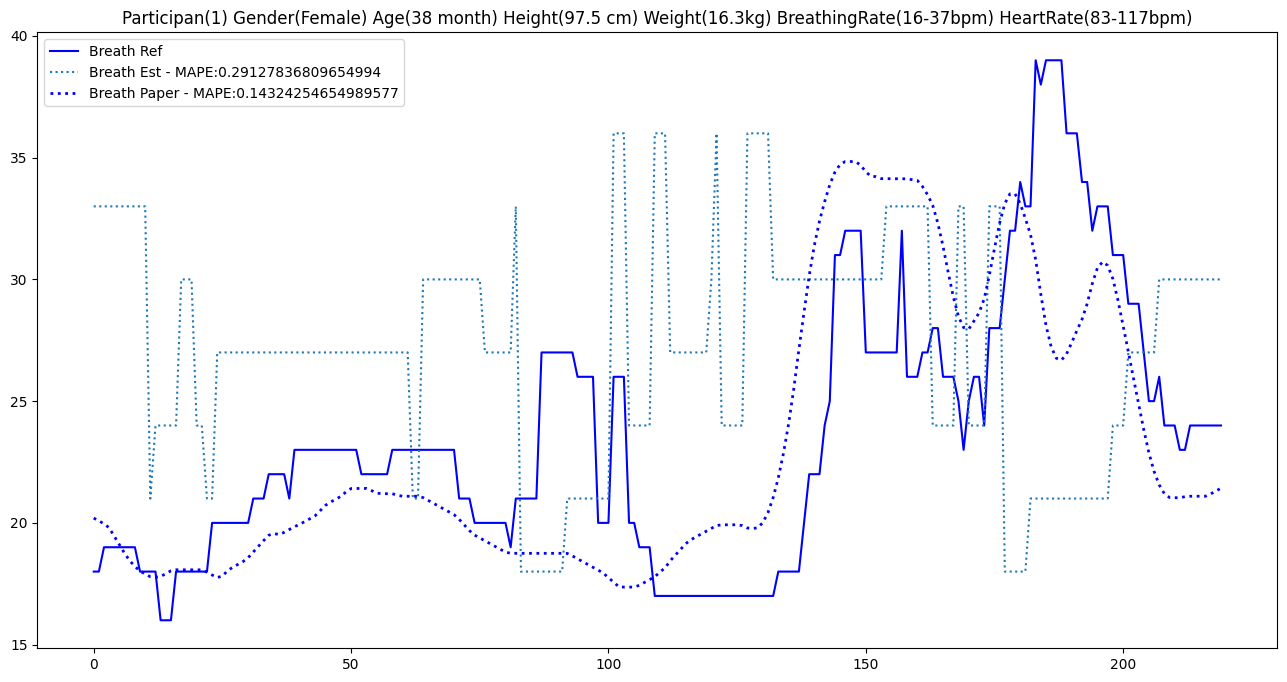

In [219]:
START_SIGNAL=20
END_SIGNAL=240
mape_br=MAPE(breaths[START_SIGNAL:END_SIGNAL],fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL])
mape_br_paper=MAPE(breaths[START_SIGNAL:END_SIGNAL],breath_est_paper[START_SIGNAL:END_SIGNAL])
plt.figure(figsize=(16,8))
plt.plot(breaths[START_SIGNAL:END_SIGNAL],color="blue",linestyle='solid',label="Breath Ref")
plt.plot(fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL],label="Breath Est - MAPE:{0}".format(mape_br),linestyle='dotted')
plt.plot(breath_est_paper[START_SIGNAL:END_SIGNAL],label="Breath Paper - MAPE:{0}".format(mape_br_paper),color="blue",linestyle='dotted',linewidth=2)
plt.title("Participan(1) Gender(Female) Age(38 month) Height(97.5 cm) Weight(16.3kg) BreathingRate(16-37bpm) HeartRate(83-117bpm)")

plt.legend()
plt.show()

(6000,)


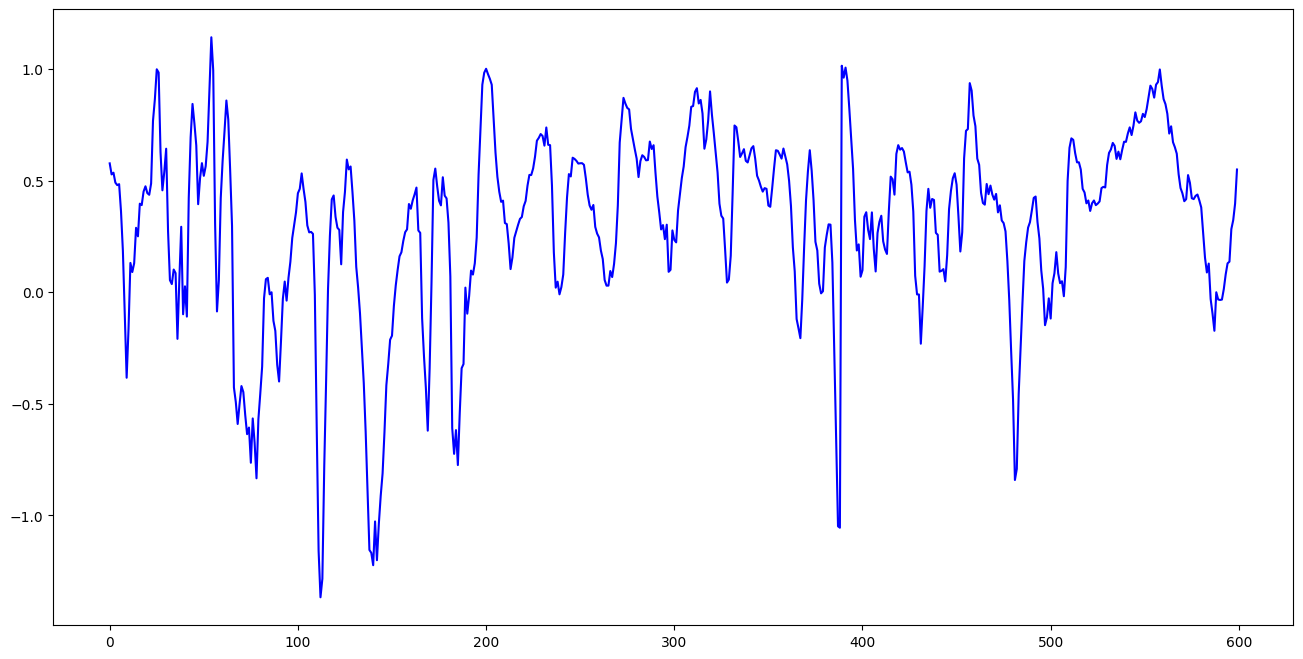

In [220]:
#hanning window with 0.5~10 samples
hanningSize=10
hanningWindow=np.hanning(hanningSize)
startIndex =0
phaseLen=len(phaseArctan)

smoothedPhase = np.empty(shape=(phaseLen,))
print(smoothedPhase.shape)
while startIndex + hanningSize <= phaseLen:
    window=phaseArctan[startIndex:startIndex+hanningSize]
    windowHanning=window*hanningWindow
    smoothedPhase[startIndex:startIndex+hanningSize] =windowHanning
    startIndex +=hanningSize
plt.figure(figsize=(16,8))
plt.plot(phaseArctan[0:600],color="blue")
#plt.plot(smoothedPhase[0:1200],color="red")
plt.show()



In [221]:
#hanning window with 2.5~50 samples
secondStartIndex=0
secondHanningSize=50
smoothedPhaseLen=len(smoothedPhase)

secondHannigWindow=np.hanning(secondHanningSize)
doubleSmoothPhase=np.empty(shape=(smoothedPhaseLen,))
k=0
while secondStartIndex+secondHanningSize<=smoothedPhaseLen:
    secondWindow=smoothedPhase[secondStartIndex:secondStartIndex+secondHanningSize]
    hanningSecondWindow= secondWindow*secondHannigWindow 
    doubleSmoothPhase[secondStartIndex:secondStartIndex+secondHanningSize] =hanningSecondWindow
    secondStartIndex+=secondHanningSize
    k+=1
# plt.figure(figsize=(16,8))
# plt.plot(phaseArctan,color="blue")
# plt.plot(smoothedPhase,color="red")
# plt.plot(doubleSmoothPhase[0:600],color="green")
# plt.show()

In [222]:
heart_signal_filtered =filter_signal(doubleSmoothPhase,0.8,2,20,6)
# est_hear_signal= heart_signal_filtered[0:400]
# peaks, _ = find_peaks(est_hear_signal,prominence=0.05)
# peakCount=len(peaks)*3
# plt.figure(figsize=(16,8))
# plt.plot(est_hear_signal,color="green")
# plt.plot(peaks,est_hear_signal[peaks],"r.")
# plt.title("{0}".format(peakCount))
# plt.show()

4   -    120.0
5   -    99.99999999999999
6   -    85.71428571428571
7   -    75.0
8   -    66.66666666666666
9   -    60.0
5  <----->  99.99999999999999
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 98.99999999999999, 98.99999999999999, 98.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.999999

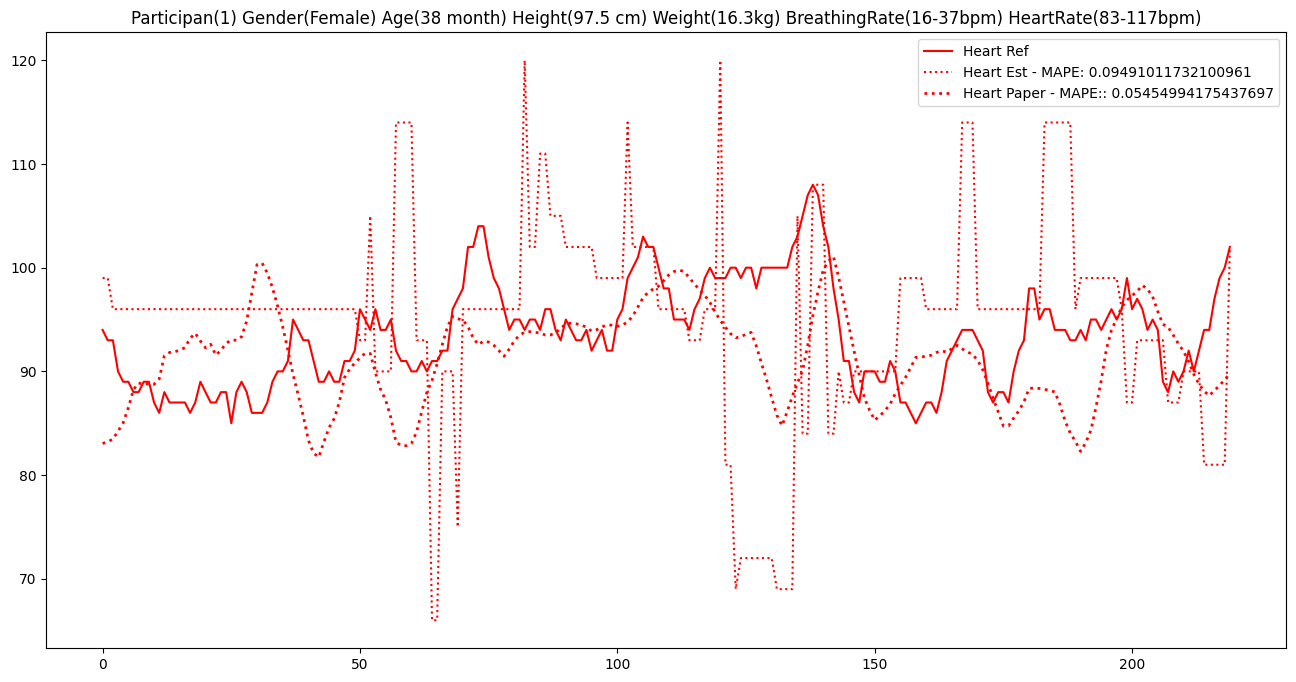

In [223]:
def estHeaftFreq(signal_for_est):
    initDuration=20
    sampling_rate=20
    window_size= initDuration*sampling_rate
    
    freq_peaks=[0]*(initDuration-1)
    overlap=20
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        hanningWinwdow= np.hanning(len(window_signal))
        window_signal =window_signal*hanningWinwdow
        windowFreq=getWindowFreq(window_signal,sampling_rate)
        freq_peaks.append(windowFreq)
        start_idx += overlap
    print(freq_peaks)
    return freq_peaks
filtered_heart_phase_arctan=filter_signal(doubleSmoothPhase,1,2,20,6)
heart_signal_est_with_wavelet_transform =estSignal(filtered_heart_phase_arctan,20,1,2)
fixed_bin_freq_heart=estHeaftFreq(heart_signal_est_with_wavelet_transform)

START_SIGNAL=20
END_SIGNAL=240

mape_br=MAPE(breaths[START_SIGNAL:END_SIGNAL],fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL])
mape_br_paper=MAPE(breaths[START_SIGNAL:END_SIGNAL],breath_est_paper[START_SIGNAL:END_SIGNAL])

mape_hr=MAPE(heart[START_SIGNAL:END_SIGNAL],fixed_bin_freq_heart[START_SIGNAL:END_SIGNAL])
mape_hr_paper=MAPE(heart[START_SIGNAL:END_SIGNAL],heart_est_paper[START_SIGNAL:END_SIGNAL])

plt.figure(figsize=(16,8))

plt.plot(heart[START_SIGNAL:END_SIGNAL],color="red",linestyle='solid',label="Heart Ref")
plt.plot(fixed_bin_freq_heart[START_SIGNAL:END_SIGNAL],label="Heart Est - MAPE: {0}".format(mape_hr),linestyle='dotted',color="red")
plt.plot(heart_est_paper[START_SIGNAL:END_SIGNAL],label="Heart Paper - MAPE:: {0}".format(mape_hr_paper),color="red",linestyle='dotted',linewidth=2)
plt.title("Participan(1) Gender(Female) Age(38 month) Height(97.5 cm) Weight(16.3kg) BreathingRate(16-37bpm) HeartRate(83-117bpm)")
plt.legend()
plt.show()

In [224]:
def moving_average_filter(input_data,window_size=5,sliding_size=1):
    retdata =[]    
    data_size = len(input_data)
    for jj in range(0,window_size-1):
        retdata.append(input_data[jj])
    start_index =0
    while start_index < data_size -window_size:
        average_value =np.average(input_data[start_index:start_index+window_size])
        retdata.append(average_value)
        start_index+=sliding_size  
    return retdata

4   -    120.0
5   -    99.99999999999999
6   -    85.71428571428571
7   -    75.0
8   -    66.66666666666666
9   -    60.0
5  <----->  99.99999999999999
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 98.99999999999999, 98.99999999999999, 98.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.99999999999999, 95.999999

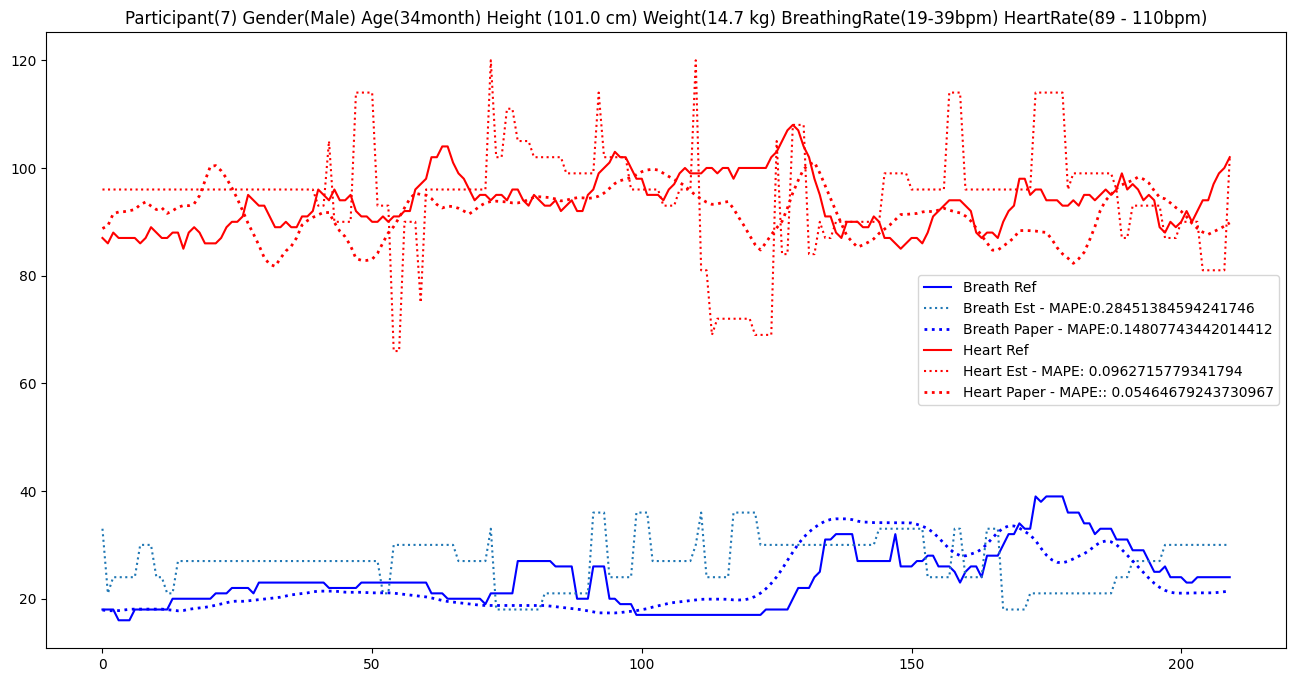

In [225]:
def estHeaftFreq(signal_for_est):
    initDuration=20
    sampling_rate=20
    window_size= initDuration*sampling_rate
    
    freq_peaks=[0]*(initDuration-1)
    overlap=20
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        hanningWinwdow= np.hanning(len(window_signal))
        window_signal =window_signal*hanningWinwdow
        windowFreq=getWindowFreq(window_signal,sampling_rate)
        freq_peaks.append(windowFreq)
        start_idx += overlap
    print(freq_peaks)
    return freq_peaks
filtered_heart_phase_arctan=filter_signal(doubleSmoothPhase,1,2,20,6)
heart_signal_est_with_wavelet_transform =estSignal(filtered_heart_phase_arctan,20,1,2)
fixed_bin_freq_heart=estHeaftFreq(heart_signal_est_with_wavelet_transform)

START_SIGNAL=30
END_SIGNAL=240

mape_br=MAPE(breaths[START_SIGNAL:END_SIGNAL],fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL])
mape_br_paper=MAPE(breaths[START_SIGNAL:END_SIGNAL],breath_est_paper[START_SIGNAL:END_SIGNAL])

mape_hr=MAPE(heart[START_SIGNAL:END_SIGNAL],fixed_bin_freq_heart[START_SIGNAL:END_SIGNAL])
mape_hr_paper=MAPE(heart[START_SIGNAL:END_SIGNAL],heart_est_paper[START_SIGNAL:END_SIGNAL])

plt.figure(figsize=(16,8))

plt.plot(breaths[START_SIGNAL:END_SIGNAL],color="blue",linestyle='solid',label="Breath Ref")
plt.plot(fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL],label="Breath Est - MAPE:{0}".format(mape_br),linestyle='dotted')
plt.plot(breath_est_paper[START_SIGNAL:END_SIGNAL],label="Breath Paper - MAPE:{0}".format(mape_br_paper),color="blue",linestyle='dotted',linewidth=2)
plt.plot(heart[START_SIGNAL:END_SIGNAL],color="red",linestyle='solid',label="Heart Ref")
plt.plot(fixed_bin_freq_heart[START_SIGNAL:END_SIGNAL],label="Heart Est - MAPE: {0}".format(mape_hr),linestyle='dotted',color="red")
plt.plot(heart_est_paper[START_SIGNAL:END_SIGNAL],label="Heart Paper - MAPE:: {0}".format(mape_hr_paper),color="red",linestyle='dotted',linewidth=2)

plt.title("Participant(7) Gender(Male) Age(34month) Height (101.0 cm) Weight(14.7 kg) BreathingRate(19-39bpm) HeartRate(89 - 110bpm)")
plt.legend()
plt.show()

In [226]:
WINSIZE=10
maf_h = moving_average_filter(fixed_bin_freq_heart,window_size=WINSIZE)
maf_b =moving_average_filter(fixed_bin_freq_breath,window_size=WINSIZE//2)

0.27582297877609047
0.08413306758077946


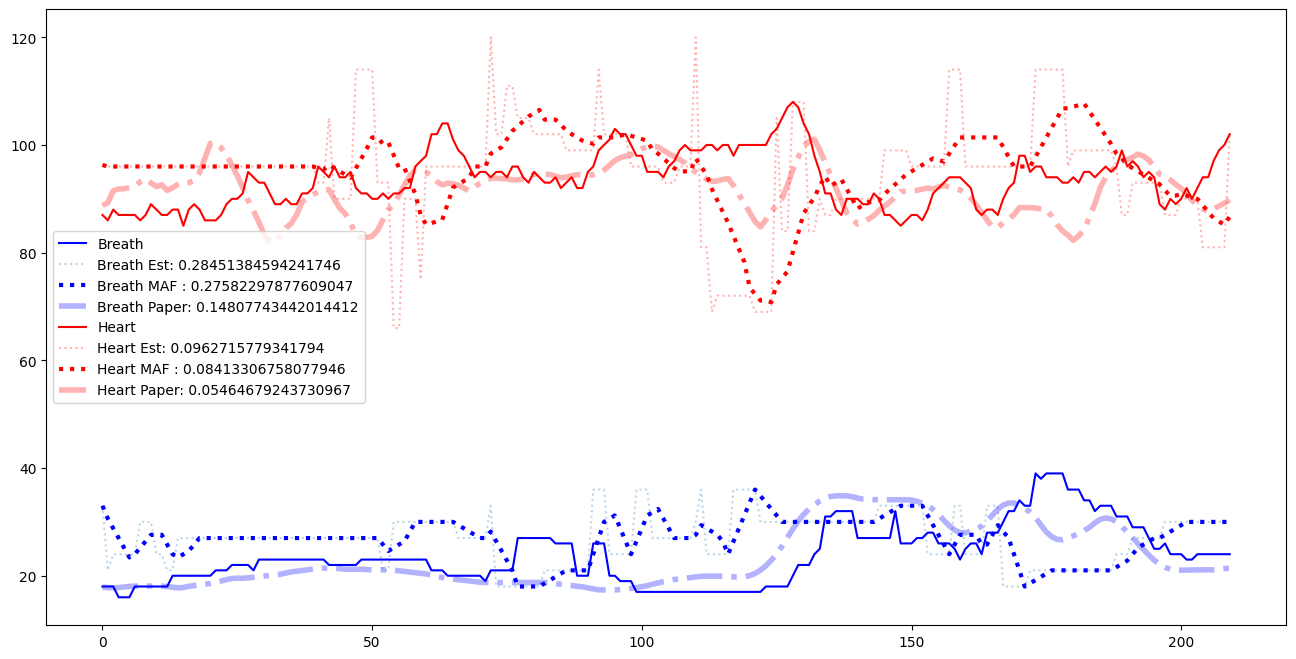

In [227]:
mape_b=MAPE(breaths[START_SIGNAL:END_SIGNAL],maf_b[START_SIGNAL:END_SIGNAL])
mape_h=MAPE(heart[START_SIGNAL:END_SIGNAL],maf_h[START_SIGNAL:END_SIGNAL])

plt.figure(figsize=(16,8))

plt.plot(breaths[START_SIGNAL:END_SIGNAL],color="blue",linestyle='solid',label="Breath")
plt.plot(fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL],label="Breath Est: {0}".format(mape_br),linestyle='dotted',alpha =0.3)
plt.plot(maf_b[START_SIGNAL:END_SIGNAL],label="Breath MAF : {0}".format(mape_b),color="blue",linestyle='dotted',linewidth=3)
plt.plot(breath_est_paper[START_SIGNAL:END_SIGNAL],label="Breath Paper: {0}".format(mape_br_paper),color="blue",linestyle='-.',linewidth=4,alpha =0.3)

plt.plot(heart[START_SIGNAL:END_SIGNAL],color="red",linestyle='solid',label="Heart")
plt.plot(fixed_bin_freq_heart[START_SIGNAL:END_SIGNAL],label="Heart Est: {0}".format(mape_hr),linestyle='dotted',color="red",alpha =0.3)
plt.plot(maf_h[START_SIGNAL:END_SIGNAL],label="Heart MAF : {0}".format(mape_h),color="red",linestyle='dotted',linewidth=3)
plt.plot(heart_est_paper[START_SIGNAL:END_SIGNAL],label="Heart Paper: {0}".format(mape_hr_paper),color="red",linestyle='-.',linewidth=4,alpha =0.3)
plt.legend()
channel_folder="./RESULT_CHANNEL{0}".format(0)
Path(channel_folder).mkdir(parents=True, exist_ok=True)
plt.savefig('{1}/WAVELET{0}.png'.format(PERSON_NUMBER,channel_folder))
plt.show()

